In [122]:
import cv2
import utils
import numpy as np
from scipy.signal import convolve
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

Код для вычисления LCS

In [141]:
def calculate_distance_to_chord(p, p0, p1):
    v = p1 - p0
    w = p - p0
    return np.abs(np.cross(v, w) / np.linalg.norm(v))
    

def calculate_LCS(contour, n_points=-1, start_option=0, window_size=5, normalized=True, smooth=1):
    assert contour.size > 0, "Contour is empty"
    assert window_size % 2 == 1, "Window size must be odd"
    assert (n_points == -1) or (n_points > 1), "Invalid number of points"
    
    start_options = ["top", "left", "bottom", "right"]
    assert (start_option in start_options) or (type(start_option) is int and start_option < contour.shape[0]), \
            "Invalid start option, possible options are int, \"top\", \"left\", \"bottom\", \"right\""
    
    assert smooth % 2 == 1, "Smooth size must be odd"
    
    r = lambda i: i % contour.shape[0]
    
    start_point_idx = 0
    if start_option is "top":
        compare = lambda p1, p2: p1.ravel()[1] < p2.ravel()[1]
    elif start_option is "left":
        compare = lambda p1, p2: p1.ravel()[0] < p2.ravel()[0]
    elif start_option is "bottom":
        compare = lambda p1, p2: p1.ravel()[1] > p2.ravel()[1]
    elif start_option is "right":
        compare = lambda p1, p2: p1.ravel()[0] > p2.ravel()[0]
    elif type(start_option) is int:
        compare = None
        start_point_idx = start_option
        
    if n_points == -1:
        n_points = contour.shape[0]
        step = 1
    else:
        step = contour.shape[0] / n_points
    
    lcs = []
    points = []
    
    for j in xrange(n_points):
        point = contour[int(j * step)]
        points.append(point)
        
        neighbors = contour[r(int(j * step) - window_size / 2), :], contour[r(int(j * step) + window_size / 2), :]
        lcs.append(calculate_distance_to_chord(point, *neighbors))
        
        if compare is not None and compare(point, contour[int(start_point_idx * step)]):
            start_point_idx = j
        
    lcs = np.roll(np.array(lcs), - start_point_idx).ravel()
    
    if smooth > 1:
        kernel = np.array([1 / smooth] * smooth)
        lcs = convolve(lcs, kernel, mode='full')
    
    if normalized:
        lcs /= lcs.max()
        
    return lcs, np.array(points), start_point_idx

Визуализируем на примерах

In [139]:
test_images = []
for j in xrange(17):
    image_name = "../data/raw/averages/{}.png".format(j)
    test_images.append(cv2.imread(image_name))
# print len(test_images)

labels_list = ['FIST-TOP', 'PALM-TOP', 'PALM-SIDE', 'RING', 'V', 'FIST-SIDE', 'THIRD-FINGER', 
               'GOAT', 'SECOND-FINGER', 'FOURTH-FINGER', 'DREI', 'POINTER', 'GOAT-INV', 'GUN', 
               'PALM-BOTTOM', 'FIRST-FINGER', 'FAN']

def get_contour(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = utils.binarize(gray)
    _, contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    return max(contours, key=cv2.contourArea)

/home/lysuhin/Distr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


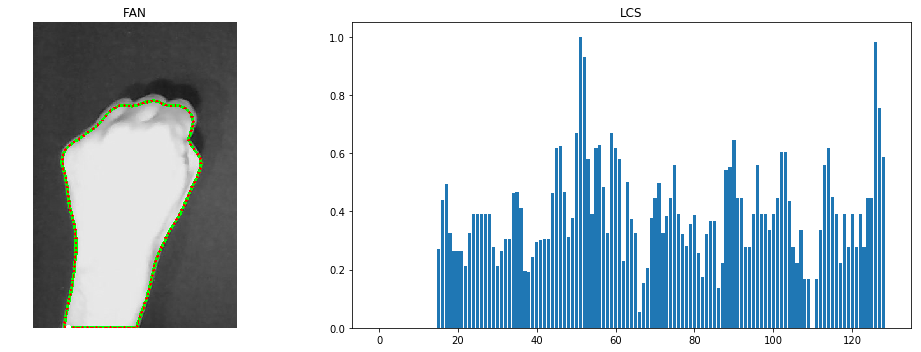

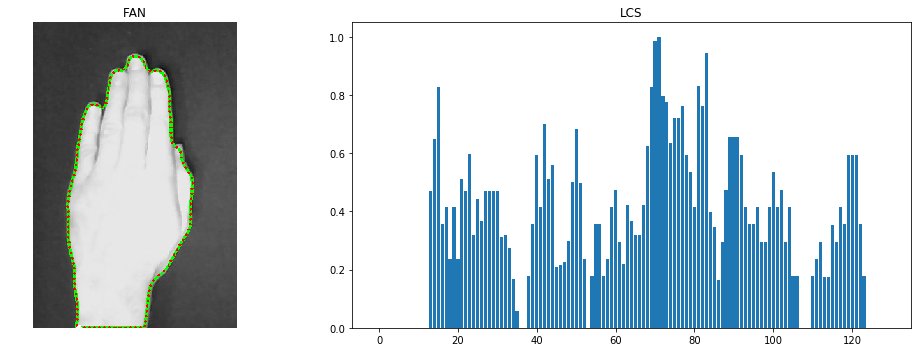

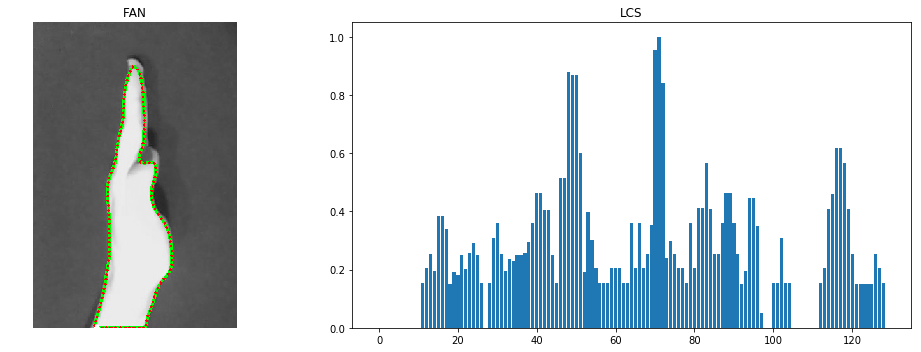

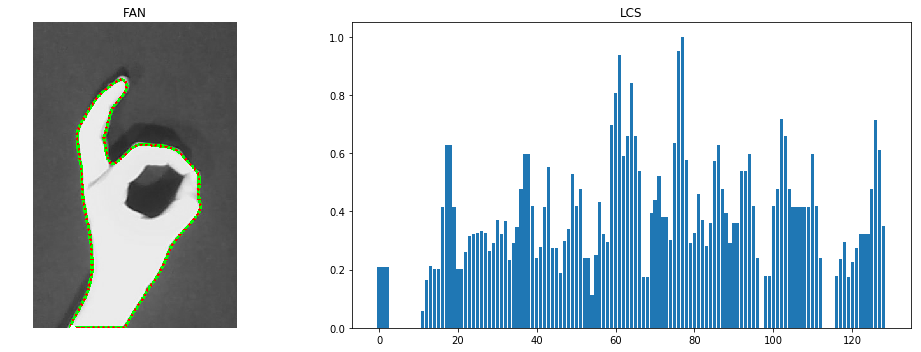

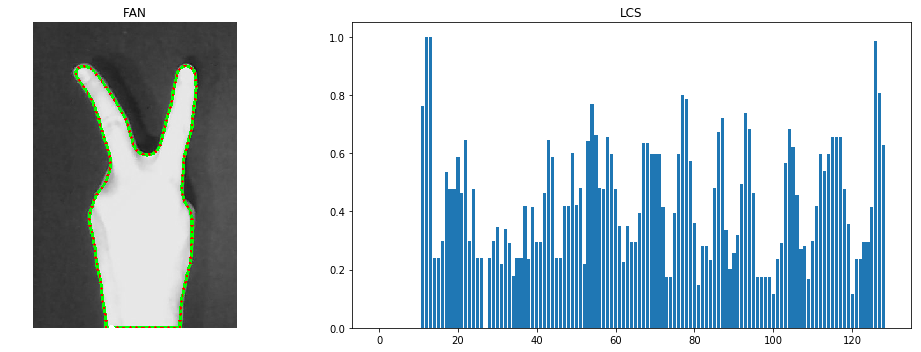

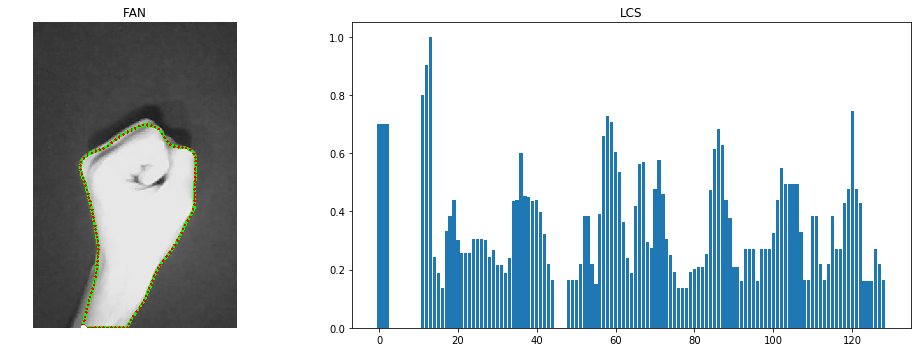

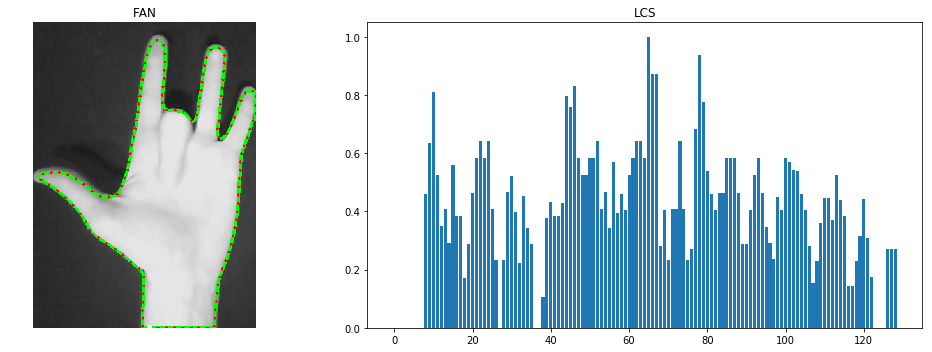

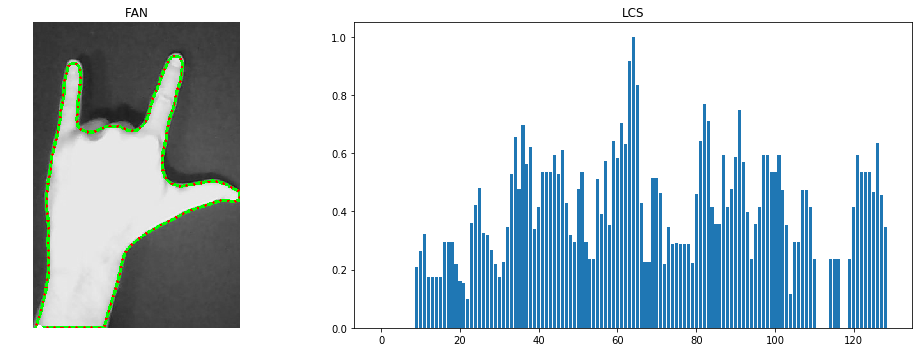

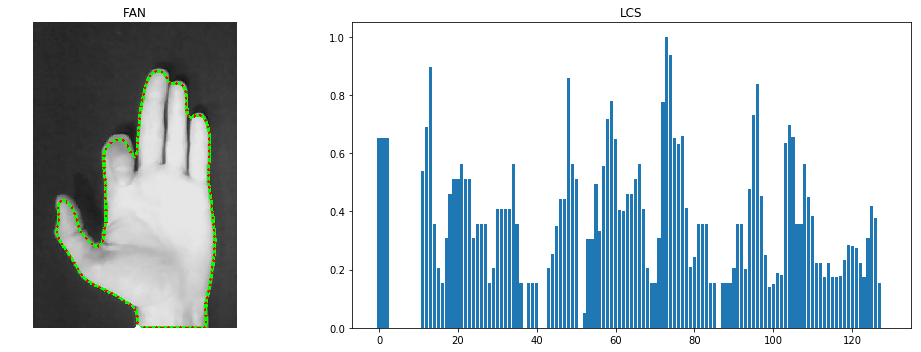

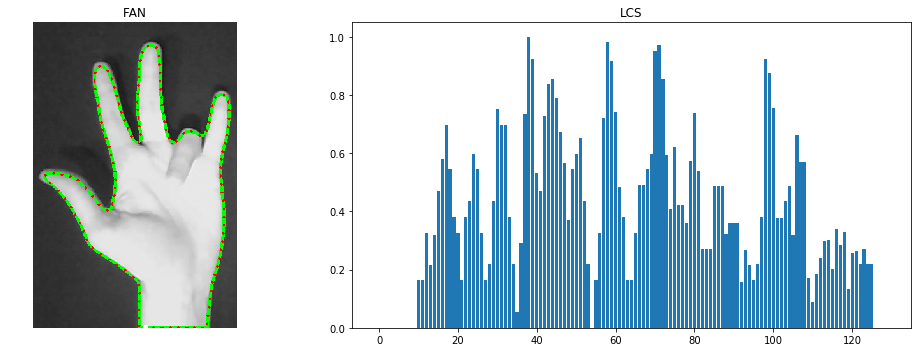

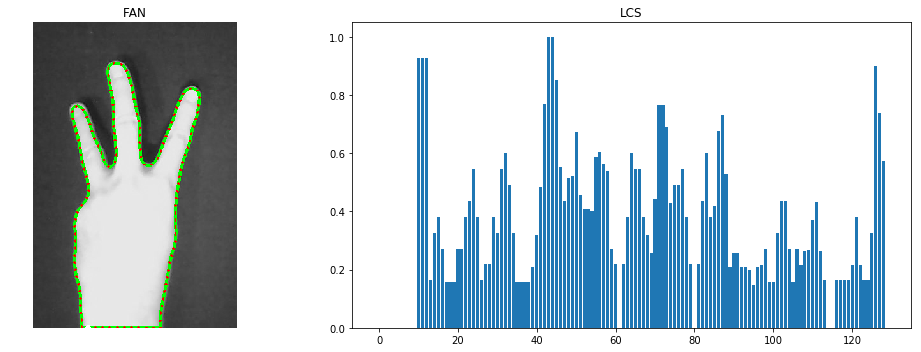

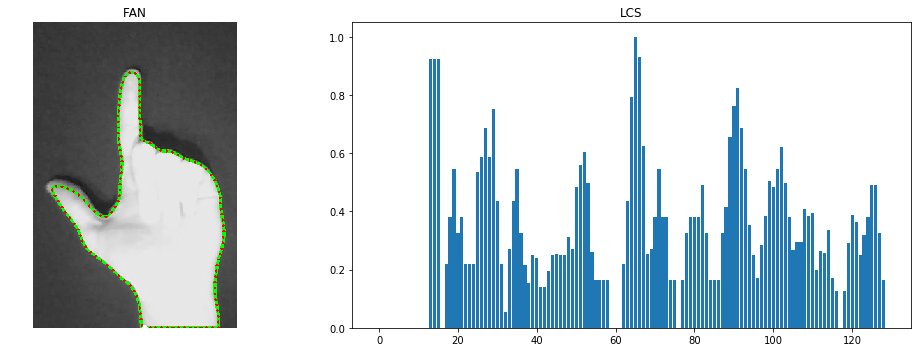

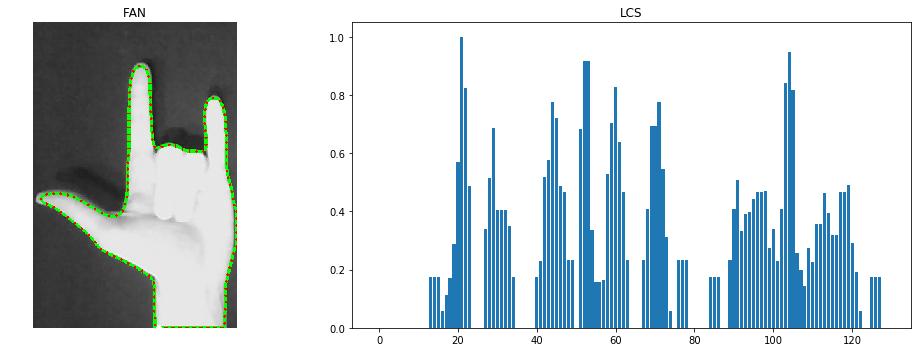

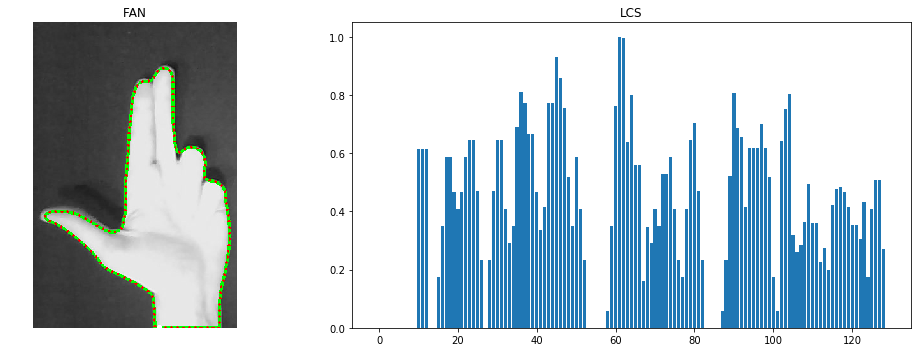

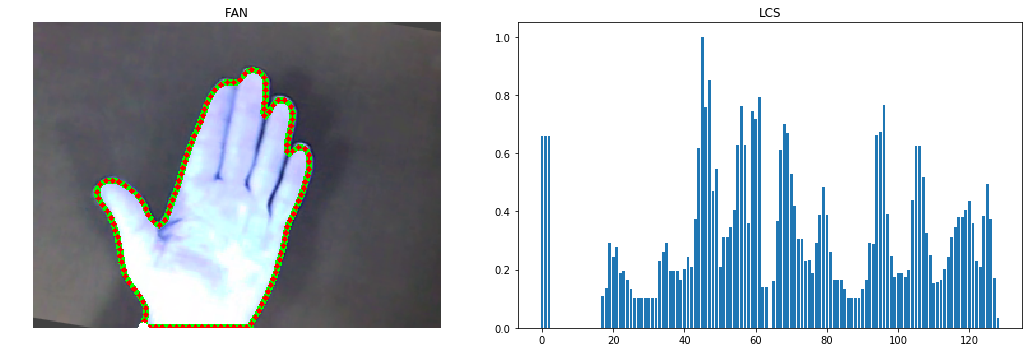

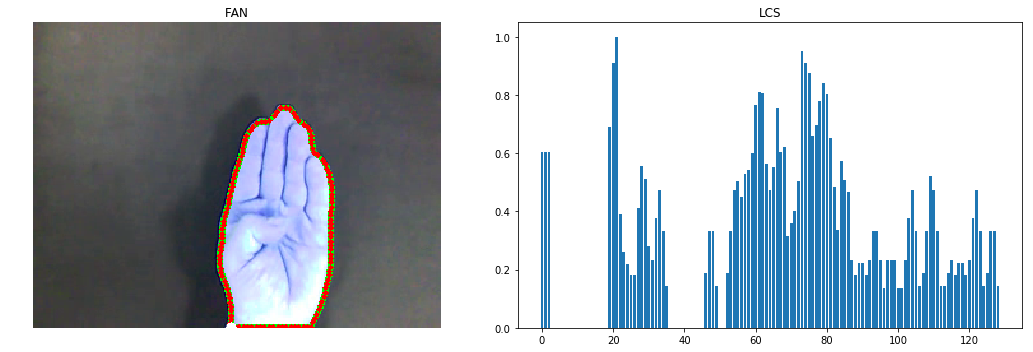

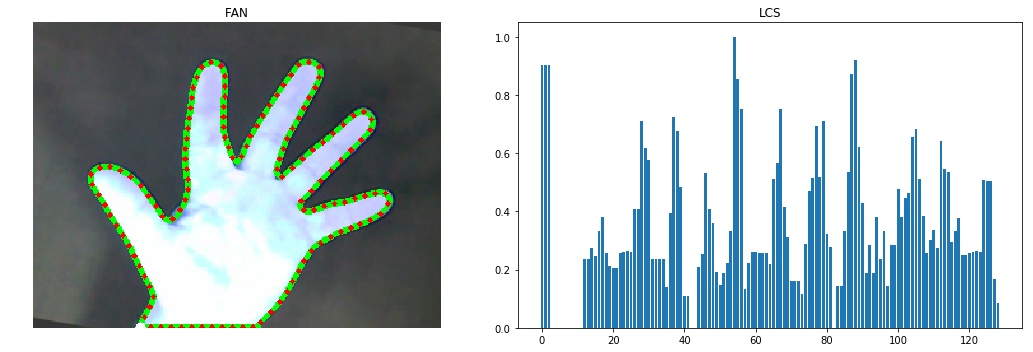

In [140]:
contours = [get_contour(image) for image in test_images]

for image in test_images:
    image_copy = image.copy()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    contour = get_contour(image)
    lcs, points, start_point_idx = calculate_LCS(contour, n_points=127, start_option="bottom", window_size=7, smooth=3)

    cv2.drawContours(image_copy, [contour], 0, (0, 255, 0), 4)
    for point in points:
        cv2.circle(image_copy, tuple(point.ravel()), 2, (255, 0, 0), -1)

    cv2.circle(image_copy, tuple(points[start_point_idx].ravel()), 4, (255, 255, 255), -1)
    
    plt.imshow(image_copy)
    plt.title(labels_list[j])
    plt.subplot(1, 2, 2)
    plt.bar(range(lcs.shape[0]), lcs)
    plt.title("LCS")
    plt.tight_layout()
    plt.show()  